In [1]:
!pip install fredapi > nul


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('fivethirtyeight')
# pd.set_option('max_columns',500)
pd.options.display.max_columns = 500

color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key = '8cca4525cb57828454768a92a57d68d2'


# 1. Create The Fred Object

In [4]:
fred= Fred(api_key=fred_key)

# 2. Search for Economic Data 


In [6]:
sp_search = fred.search('S&P', order_by='popularity')

In [7]:
sp_search.head()

id realtime_start realtime_end  \
series id                                                    
BAMLH0A0HYM2      BAMLH0A0HYM2     2024-08-04   2024-08-04   
CSUSHPINSA          CSUSHPINSA     2024-08-04   2024-08-04   
SP500                    SP500     2024-08-04   2024-08-04   
MEHOINUSA672N    MEHOINUSA672N     2024-08-04   2024-08-04   
BAMLH0A0HYM2EY  BAMLH0A0HYM2EY     2024-08-04   2024-08-04   

                                                            title  \
series id                                                           
BAMLH0A0HYM2    ICE BofA US High Yield Index Option-Adjusted S...   
CSUSHPINSA      S&P CoreLogic Case-Shiller U.S. National Home ...   
SP500                                                     S&P 500   
MEHOINUSA672N   Real Median Household Income in the United States   
BAMLH0A0HYM2EY       ICE BofA US High Yield Index Effective Yield   

               observation_start observation_end     frequency  \
series id                                                        
BAMLH0A0HYM2          1996-12-31      2024-08-01  Daily, Close   
CSUSHPINSA            1987-01-01      2024-05-01       Monthly   
SP500                 2014-08-04      2024-08-02  Daily, Close   
MEHOINUSA672N         1984-01-01      2022-01-01        Annual   
BAMLH0A0HYM2EY        1996-12-31      2024-08-01  Daily, Close   

               frequency_short                           units  \
series id                                                        
BAMLH0A0HYM2                 D                         Percent   
CSUSHPINSA                   M              Index Jan 2000=100   
SP500                        D                           Index   
MEHOINUSA672N                A  2022 CPI-U-RS Adjusted Dollars   
BAMLH0A0HYM2EY               D                         Percent   

                             units_short      seasonal_adjustment  \
series id                                                           
BAMLH0A0HYM2                           %  Not Seasonally Adjusted   
CSUSHPINSA            Index Jan 2000=100  Not Seasonally Adjusted   
SP500                              Index  Not Seasonally Adjusted   
MEHOINUSA672N   2022 CPI-U-RS Adjusted $  Not Seasonally Adjusted   
BAMLH0A0HYM2EY                         %  Not Seasonally Adjusted   

               seasonal_adjustment_short               last_updated  \
series id                                                             
BAMLH0A0HYM2                         NSA  2024-08-02 09:32:20-05:00   
CSUSHPINSA                           NSA  2024-07-30 08:11:01-05:00   
SP500                                NSA  2024-08-02 19:57:09-05:00   
MEHOINUSA672N                        NSA  2023-09-12 13:48:02-05:00   
BAMLH0A0HYM2EY                       NSA  2024-08-02 09:32:22-05:00   

               popularity                                              notes  
series id                                                                     
BAMLH0A0HYM2           92  The ICE BofA Option-Adjusted Spreads (OASs) ar...  
CSUSHPINSA             88  For more information regarding the index, plea...  
SP500                  83  The observations for the S&P 500 represent the...  
MEHOINUSA672N          83  Household data are collected as of March.  As ...  
BAMLH0A0HYM2EY         82  This data represents the effective yield of th...

# 3. Pull Raw Data & Plot

In [9]:
sp500 = fred.get_series(series_id='SP500')

<Axes: title={'center': 'S&P 500'}>

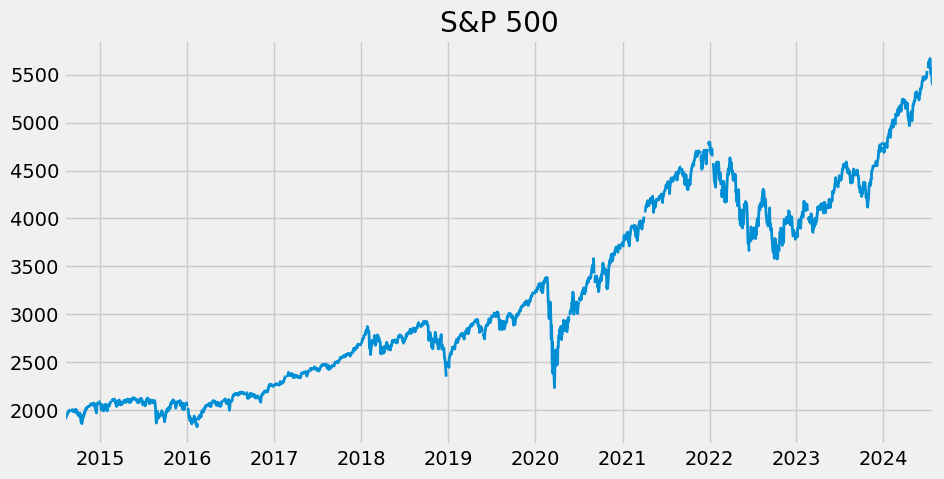

In [10]:
sp500.plot(figsize=(10,5), title='S&P 500', lw=2)

# 4. Pull and Join Multiple Data Series

In [12]:
unemp_df = fred.search('unemployment state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units=="Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [13]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)

unemp_results = pd.concat(all_results, axis=1)

In [14]:
# Define the regex pattern to match columns starting with 'LNS', 'LRUN', 'LASM'
regex_pattern = '^(LNS|LRUN|LASM)'

# Get the columns to drop based on the regex pattern
columns_to_drop = unemp_results.filter(regex=regex_pattern).columns.tolist()

# Define the specific columns to drop
specific_columns_to_drop = ['U2RATE', 'CMWRUR', 'CSOUUR', 'CNERUR', 'CWSTUR', 'CNEWUR','M08311USM156SNBR','M08320USM156SNBR','M0892AUSM156SNBR','M0892BUSM156SNBR']

# Combine both lists of columns to drop
all_columns_to_drop = columns_to_drop + specific_columns_to_drop

# Drop the columns from the DataFrame
unemp_results = unemp_results.drop(columns=all_columns_to_drop)

In [15]:
unemp_states = unemp_results.drop('UNRATE', axis=1)
unemp_states = unemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
unemp_states.columns = [id_to_state[c] for c in unemp_states.columns ]

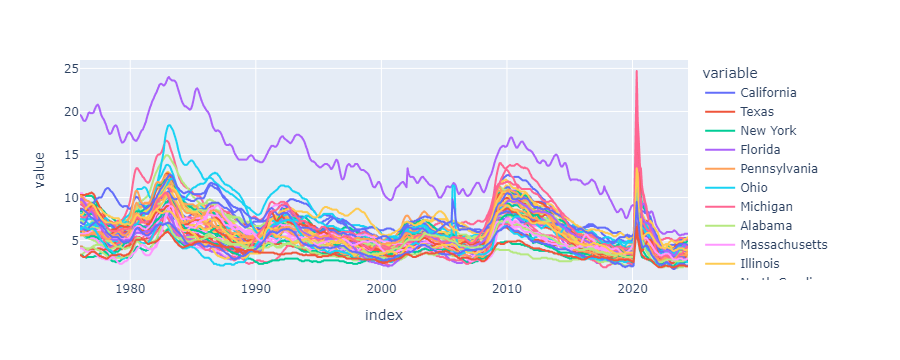

In [16]:
# Plot states unemployment rate
px.line(unemp_states)

## Pull April 2020 Unemployment Rate Per State

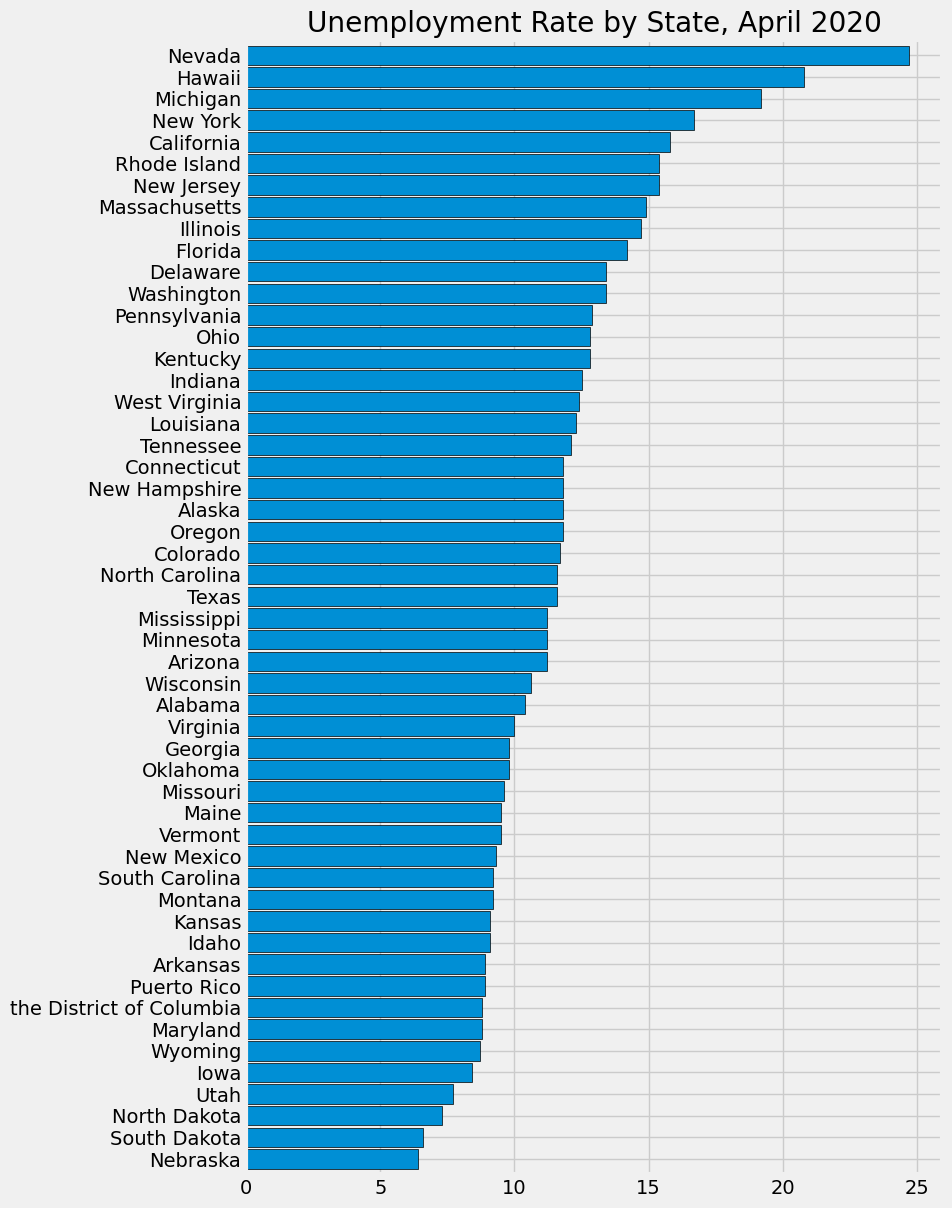

In [18]:
ax = unemp_states.loc[unemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8,14), width=0.9, edgecolor='black' ,
          title='Unemployment Rate by State, April 2020')

ax.legend().remove()


# Pull Participation Rate

In [20]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units=="Percent"')

In [21]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)

part_states = pd.concat(all_results, axis=1)


In [22]:
part_states

CIVPART  LNS11300060  LNS11300002  LNS11300001  LNS11324230  \
1948-01-01     58.6         64.2         32.0         86.7         43.0   
1948-02-01     58.9         64.6         32.4         87.0         43.3   
1948-03-01     58.5         64.3         32.1         86.3         43.0   
1948-04-01     59.0         64.8         33.0         86.6         43.4   
1948-05-01     58.3         64.3         32.0         86.1         43.2   
...             ...          ...          ...          ...          ...   
2024-03-01     62.7         83.4         57.6         68.0         38.6   
2024-04-01     62.7         83.5         57.7         67.9         38.4   
2024-05-01     62.5         83.6         57.6         67.8         38.2   
2024-06-01     62.6         83.7         57.3         68.1         38.2   
2024-07-01     62.7         84.0         57.5         68.2         38.3   

            LNS11300012  LNS11300006  LRAC25MAUSM156S  LNS11300036  \
1948-01-01         53.2          NaN              NaN         64.4   
1948-02-01         53.7          NaN              NaN         64.9   
1948-03-01         54.1          NaN              NaN         63.3   
1948-04-01         54.2          NaN              NaN         63.7   
1948-05-01         50.9          NaN              NaN         63.7   
...                 ...          ...              ...          ...   
2024-03-01         38.2         63.6             89.2         72.1   
2024-04-01         37.6         63.2             89.1         72.4   
2024-05-01         38.1         62.9             89.2         70.8   
2024-06-01         37.4         62.7             89.6         71.0   
2024-07-01         36.4         63.2              NaN         71.3   

            LRAC25FEUSM156S  LNS11327662  LBSSA06  LNS11300028  LNS11300031  \
1948-01-01              NaN          NaN      NaN          NaN          NaN   
1948-02-01              NaN          NaN      NaN          NaN          NaN   
1948-03-01              NaN          NaN      NaN          NaN          NaN   
1948-04-01              NaN          NaN      NaN          NaN          NaN   
1948-05-01              NaN          NaN      NaN          NaN          NaN   
...                     ...          ...      ...          ...          ...   
2024-03-01             77.7         72.4     62.0         69.8         69.6   
2024-04-01             78.0         72.8     62.0         69.8         68.7   
2024-05-01             78.1         72.8     62.0         69.6         68.3   
2024-06-01             77.9         72.8     62.0         70.0         69.1   
2024-07-01              NaN         72.7      NaN         70.1         69.7   

            LBSSA01  LNS11300003  LNS11327660  LBSSA36  LNS11300029  LBSSA26  \
1948-01-01      NaN          NaN          NaN      NaN          NaN      NaN   
1948-02-01      NaN          NaN          NaN      NaN          NaN      NaN   
1948-03-01      NaN          NaN          NaN      NaN          NaN      NaN   
1948-04-01      NaN          NaN          NaN      NaN          NaN      NaN   
1948-05-01      NaN          NaN          NaN      NaN          NaN      NaN   
...             ...          ...          ...      ...          ...      ...   
2024-03-01     57.4         62.3         57.3     61.4         57.9     62.3   
2024-04-01     57.5         62.3         56.7     61.3         58.0     62.3   
2024-05-01     57.5         62.2         56.8     61.3         57.8     62.3   
2024-06-01     57.5         62.2         57.0     61.3         57.6     62.3   
2024-07-01      NaN         62.3         57.0      NaN         57.8      NaN   

            LBSSA28  LNS11300009  LNS11300032  LBSSA48  LBSSA12  LBSSA21  \
1948-01-01      NaN          NaN          NaN      NaN      NaN      NaN   
1948-02-01      NaN          NaN          NaN      NaN      NaN      NaN   
1948-03-01      NaN          NaN          NaN      NaN      NaN      NaN   
1948-04-01      NaN          NaN          NaN      NaN  

In [23]:
# List of states and their corresponding codes
columns_with_state_names = [
    'California', 'Alabama', 'New York', 'Michigan', 'Mississippi', 'Texas', 'Florida',
    'Kentucky', 'Ohio', 'Wisconsin', 'Pennsylvania', 'Massachusetts', 'Minnesota',
    'Maryland', 'West Virginia', 'Tennessee', 'Maine', 'Illinois', 'North Carolina',
    'Georgia', 'Louisiana', 'South Carolina', 'Colorado', 'Utah', 'Virginia', 'Indiana',
    'Missouri', 'New Jersey', 'Iowa', 'Alaska', 'Washington', 'Arizona', 'New Mexico',
    'Idaho', 'Arkansas', 'Oklahoma', 'Nebraska', 'Hawaii', 'Nevada', 'Montana',
    'Oregon', 'New Hampshire', 'Vermont', 'Connecticut', 'North Dakota', 'South Dakota',
    'Kansas', 'Rhode Island', 'District Of Columbia', 'Delaware', 'Wyoming'
]

corresponding_codes = [
    'LBSSA06', 'LBSSA01', 'LBSSA36', 'LBSSA26', 'LBSSA28', 'LBSSA48', 'LBSSA12', 
    'LBSSA21', 'LBSSA39', 'LBSSA55', 'LBSSA42', 'LBSSA25', 'LBSSA27', 'LBSSA24', 
    'LBSSA54', 'LBSSA47', 'LBSSA23', 'LBSSA17', 'LBSSA37', 'LBSSA13', 'LBSSA22', 
    'LBSSA45', 'LBSSA08', 'LBSSA49', 'LBSSA51', 'LBSSA18', 'LBSSA29', 'LBSSA34', 
    'LBSSA19', 'LBSSA02', 'LBSSA53', 'LBSSA04', 'LBSSA35', 'LBSSA16', 'LBSSA05', 
    'LBSSA40', 'LBSSA31', 'LBSSA15', 'LBSSA32', 'LBSSA30', 'LBSSA41', 'LBSSA33', 
    'LBSSA50', 'LBSSA09', 'LBSSA38', 'LBSSA46', 'LBSSA20', 'LBSSA44', 'LBSSA11', 
    'LBSSA10', 'LBSSA56'
]

# Create a dictionary for mapping state names to their codes
state_code_dict = dict(zip(columns_with_state_names, corresponding_codes))

# Identify columns that correspond to state names
columns_to_keep = [code for code in corresponding_codes if code in part_states.columns]

# Drop columns that do not correspond to state names
part_states = part_states[columns_to_keep]


In [24]:
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

In [25]:
part_states = part_states.dropna()

In [93]:
part_states

California  Alabama  New York  Michigan  Mississippi  Texas  \
1976-01-01        62.6     57.0      58.0      61.6         58.8   63.8   
1976-02-01        62.4     56.9      58.0      61.5         58.6   63.5   
1976-03-01        62.2     56.8      58.0      61.5         58.5   63.4   
1976-04-01        62.2     56.8      58.0      61.6         58.5   63.5   
1976-05-01        62.3     56.8      58.1      61.7         58.5   63.6   
...                ...      ...       ...       ...          ...    ...   
2024-02-01        62.1     57.4      61.4      62.2         53.7   64.1   
2024-03-01        62.0     57.4      61.4      62.3         53.7   64.1   
2024-04-01        62.0     57.5      61.3      62.3         53.7   64.2   
2024-05-01        62.0     57.5      61.3      62.3         53.8   64.2   
2024-06-01        62.0     57.5      61.3      62.3         54.0   64.3   

            Florida  Kentucky  Ohio  Wisconsin  Pennsylvania  Massachusetts  \
1976-01-01     55.8      60.5  61.7       65.6          58.4           64.8   
1976-02-01     55.7      60.3  61.7       65.5          58.3           64.7   
1976-03-01     55.5      60.2  61.7       65.4          58.3           64.6   
1976-04-01     55.5      60.1  61.6       65.4          58.3           64.6   
1976-05-01     55.4      60.1  61.6       65.5          58.3           64.6   
...             ...       ...   ...        ...           ...            ...   
2024-02-01     59.4      56.9  61.8       65.7          62.5           64.8   
2024-03-01     59.4      56.9  61.8       65.6          62.7           64.9   
2024-04-01     59.3      57.1  61.8       65.6          62.9           65.1   
2024-05-01     59.1      57.3  61.9       65.6          62.9           65.3   
2024-06-01     58.9      57.4  62.1       65.5          62.9           65.7   

            Minnesota  Maryland  West Virginia  Tennessee  Maine  Illinois  \
1976-01-01       65.6      64.3           52.5       59.6   62.1      63.0   
1976-02-01       65.5      64.2           52.4       59.4   61.9      63.0   
1976-03-01       65.4      64.1           52.3       59.3   61.9      62.9   
1976-04-01       65.4      64.1           52.3       59.3   61.8      62.9   
1976-05-01       65.5      64.1           52.2       59.4   61.7      63.0   
...               ...       ...            ...        ...    ...       ...   
2024-02-01       67.9      65.0           55.2       59.5   59.3      64.6   
2024-03-01       68.0      65.0           55.2       59.6   59.3      64.6   
2024-04-01       68.0      65.2           55.2       59.6   59.4      64.7   
2024-05-01       68.0      65.3           55.1       59.6   59.5      64.9   
2024-06-01       67.8      65.4           55.1       59.5   59.6      64.9   

            North Carolina  Georgia  Louisiana  South Carolina  Colorado  \
1976-01-01            66.5     63.7       56.8            65.3      67.2   
1976-02-01            66.3     63.6       56.6            65.2      67.0   
1976-03-01            66.2     63.5       56.5            65.0      66.8   
1976-04-01            66.2     63.5       56.4            64.9      66.6   
1976-05-01            66.3     63.6       56.4            64.7      66.5   
...                    ...      ...        ...             ...       ...   
2024-02-01            60.7     61.4       58.7            57.1      68.1   
2024-03-01            60.6     61.4       58.7            57.1      68.0   
2024-04-01            60.6     61.5       58.8            57.2      68.0   
2024-05-01            60.5     61.6       58.6            57.2      67.9   
2024-06-01            60.5     61.7       58.6            57.3      67.9   

            Utah  Virginia  Indiana  Missouri  New Jersey  Iowa  Alaska  \
1976-01-01  62.8      65.9     64.0      60.5        61.5  64.4    69.0   
1976-02-01  62.6      65.8     63.9      60.3        61.4  64.3    68.4   
1976-03-01  62.5      65.6     63.8      60.3        61.4  64.2    67.8   
1976-04-01  

# Plot Unemployment vs Participation

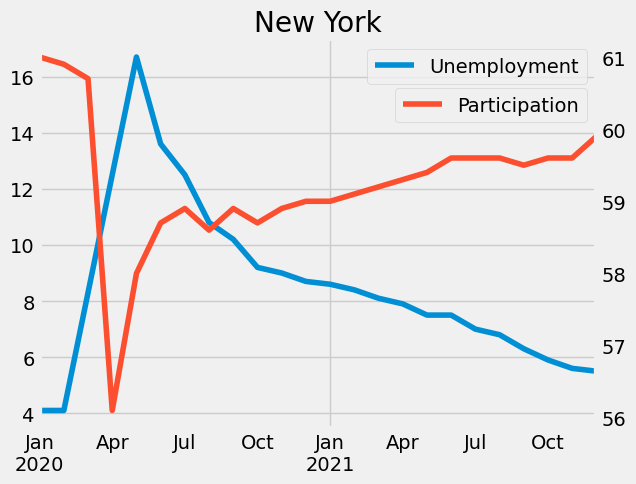

In [111]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

part_states.query('index >= 2020 and index < 2022')['New York'].plot(ax=ax2, label='Participation', color=color_pal[1])

unemp_states.query('index >= 2020 and index < 2022')['New York'].plot(ax=ax, label='Unemployment')

ax2.grid(False)
ax.set_title('New York')

ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

In [29]:
unemp_states = unemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

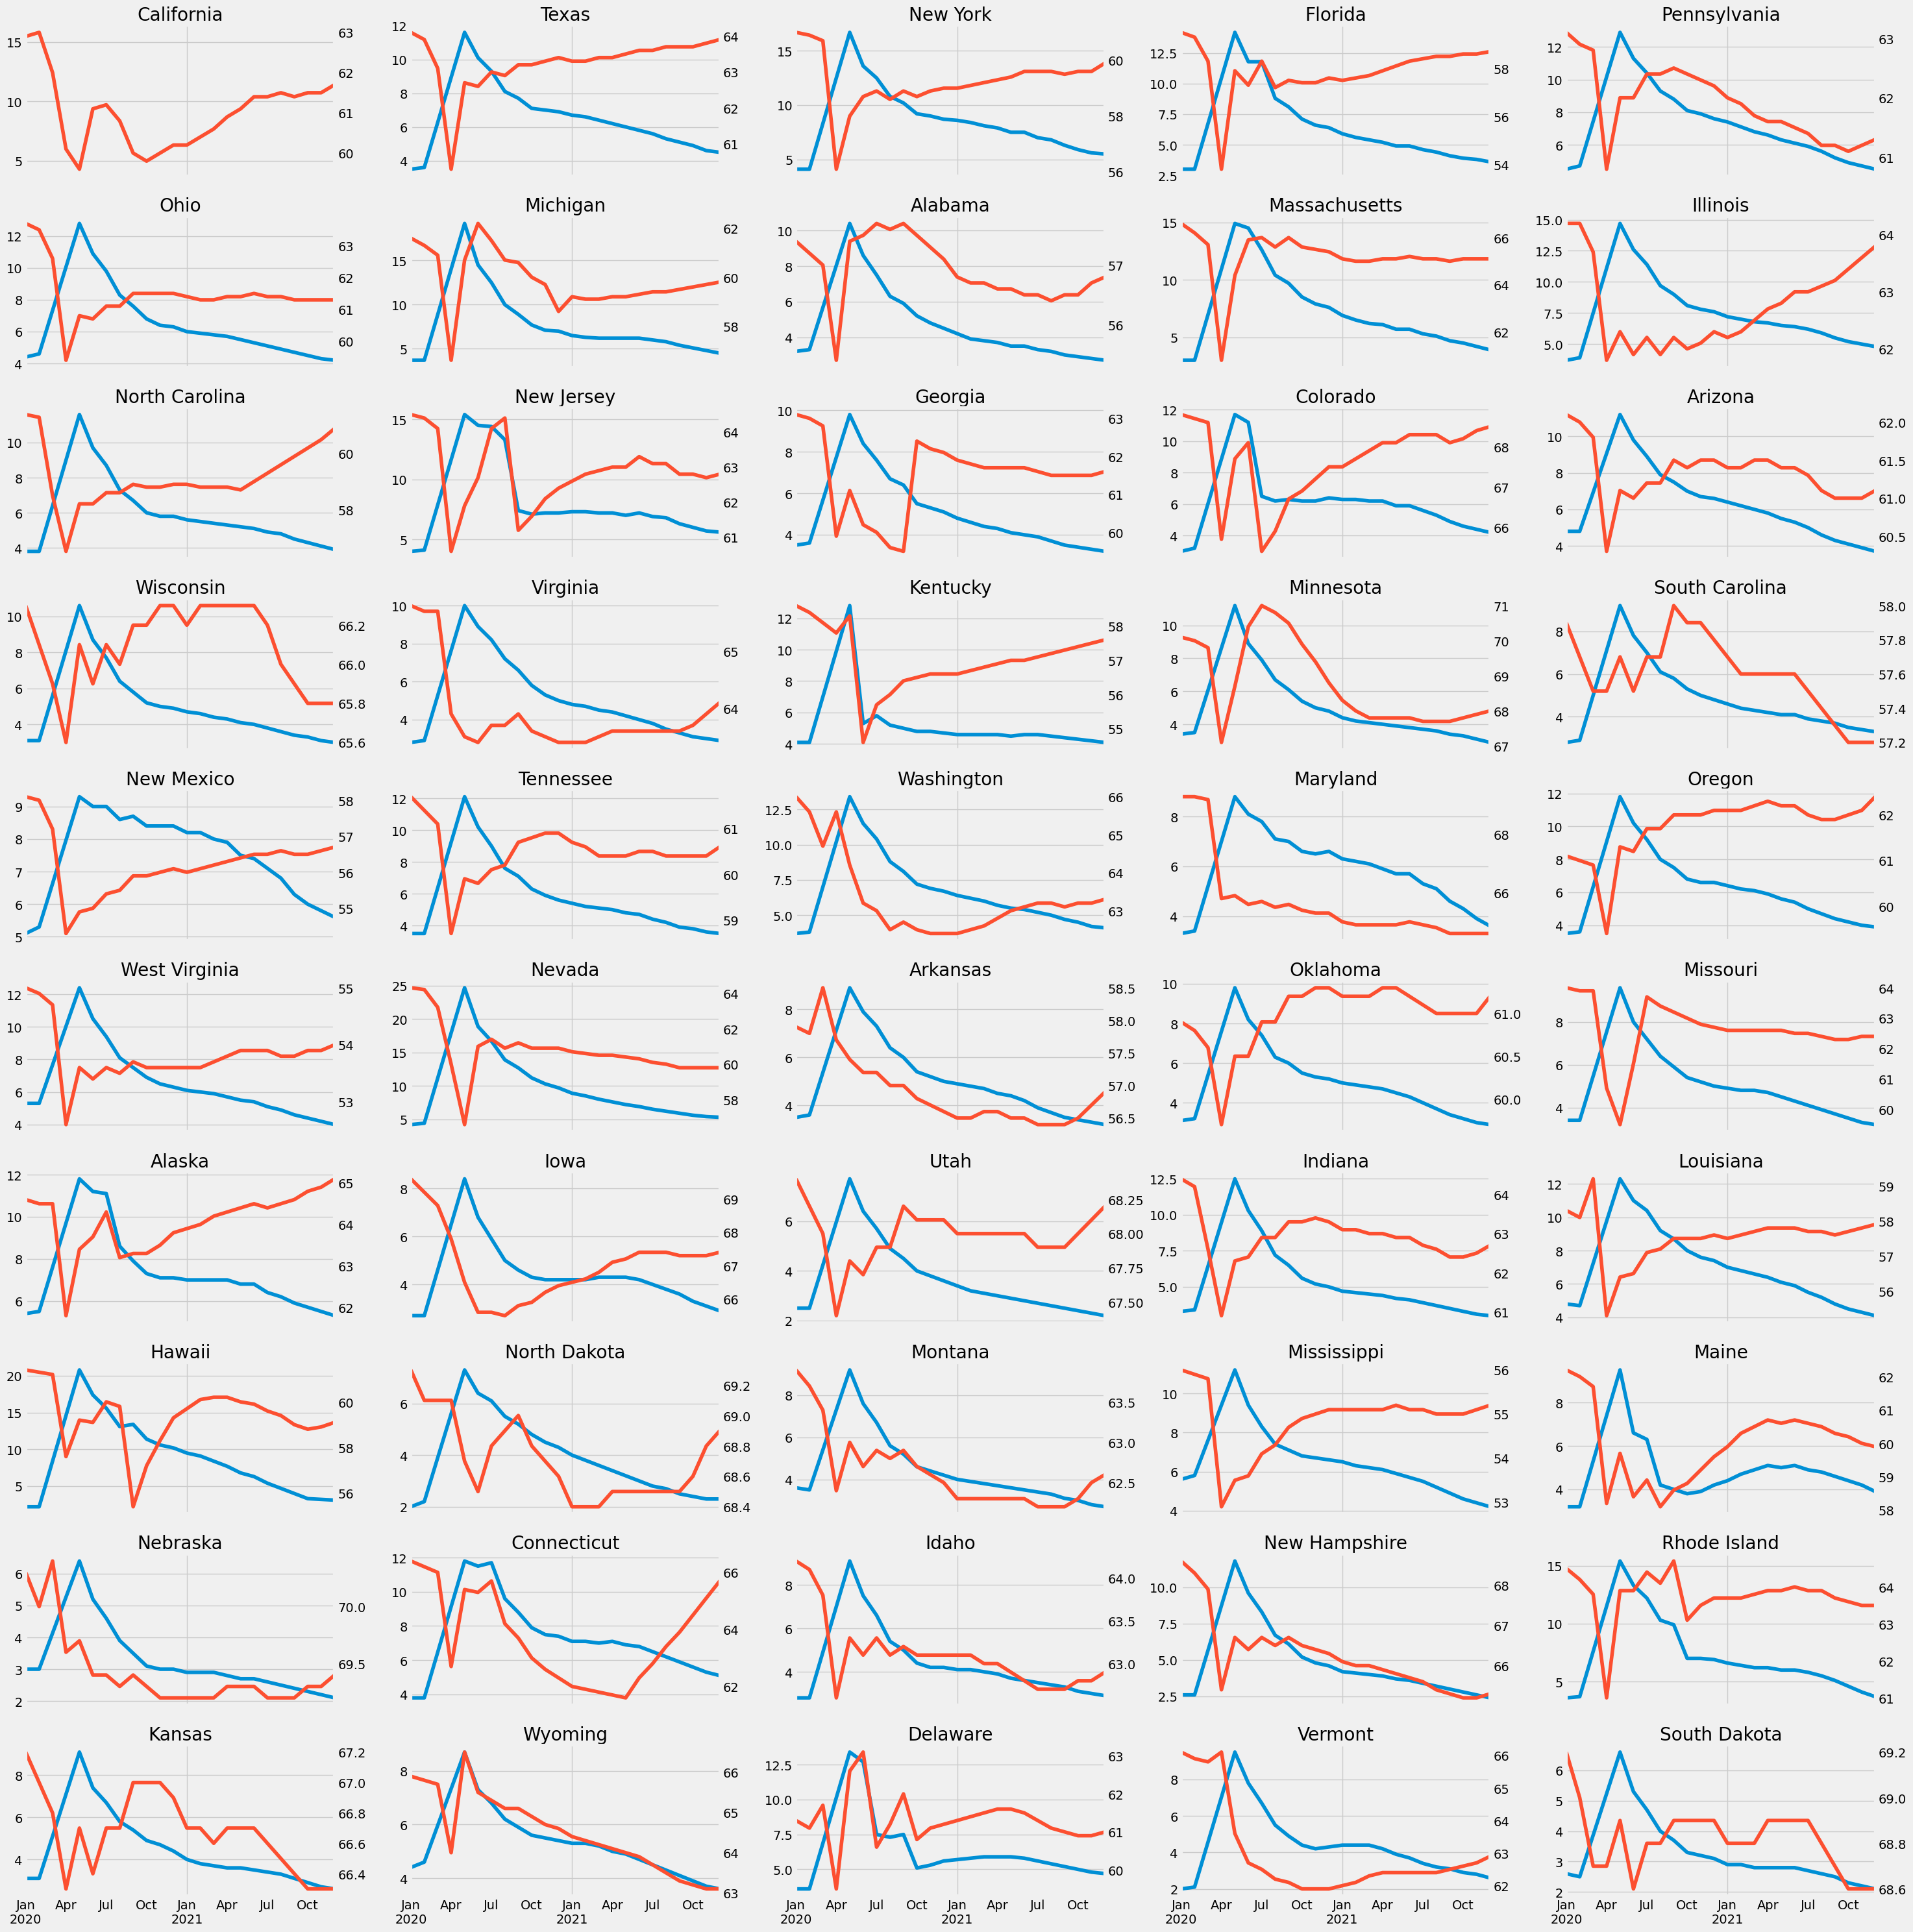

In [91]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in unemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    unemp_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()